**When you're done running the code, please click Kernel-Shutdown!**

In [1]:
%matplotlib inline

In [2]:
!unzip -o hymenoptera_data.zip

Archive:  hymenoptera_data.zip
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_data/train/ants/1473187633_63ccaacea6.jpg  
  inflating: hymenoptera_data/train/ants/148715752_302c84f5a4.jpg  
  inflating: hymenop

  inflating: hymenoptera_data/train/bees/2528444139_fa728b0f5b.jpg  
  inflating: hymenoptera_data/train/bees/2538361678_9da84b77e3.jpg  
  inflating: hymenoptera_data/train/bees/2551813042_8a070aeb2b.jpg  
  inflating: hymenoptera_data/train/bees/2580598377_a4caecdb54.jpg  
  inflating: hymenoptera_data/train/bees/2601176055_8464e6aa71.jpg  
  inflating: hymenoptera_data/train/bees/2610833167_79bf0bcae5.jpg  
  inflating: hymenoptera_data/train/bees/2610838525_fe8e3cae47.jpg  
  inflating: hymenoptera_data/train/bees/2617161745_fa3ebe85b4.jpg  
  inflating: hymenoptera_data/train/bees/2625499656_e3415e374d.jpg  
  inflating: hymenoptera_data/train/bees/2634617358_f32fd16bea.jpg  
  inflating: hymenoptera_data/train/bees/2638074627_6b3ae746a0.jpg  
  inflating: hymenoptera_data/train/bees/2645107662_b73a8595cc.jpg  
  inflating: hymenoptera_data/train/bees/2651621464_a2fa8722eb.jpg  
  inflating: hymenoptera_data/train/bees/2652877533_a564830cbf.jpg  
  inflating: hymenoptera_data/trai

  inflating: hymenoptera_data/val/bees/1519368889_4270261ee3.jpg  
  inflating: hymenoptera_data/val/bees/152789693_220b003452.jpg  
  inflating: hymenoptera_data/val/bees/177677657_a38c97e572.jpg  
  inflating: hymenoptera_data/val/bees/1799729694_0c40101071.jpg  
  inflating: hymenoptera_data/val/bees/181171681_c5a1a82ded.jpg  
  inflating: hymenoptera_data/val/bees/187130242_4593a4c610.jpg  
  inflating: hymenoptera_data/val/bees/203868383_0fcbb48278.jpg  
  inflating: hymenoptera_data/val/bees/2060668999_e11edb10d0.jpg  
  inflating: hymenoptera_data/val/bees/2086294791_6f3789d8a6.jpg  
  inflating: hymenoptera_data/val/bees/2103637821_8d26ee6b90.jpg  
  inflating: hymenoptera_data/val/bees/2104135106_a65eede1de.jpg  
  inflating: hymenoptera_data/val/bees/215512424_687e1e0821.jpg  
  inflating: hymenoptera_data/val/bees/2173503984_9c6aaaa7e2.jpg  
  inflating: hymenoptera_data/val/bees/220376539_20567395d8.jpg  
  inflating: hymenoptera_data/val/bees/224841383_d050f5f510.jpg  
  i


Transfer Learning for Computer Vision Tutorial
==============================================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at `cs231n notes <https://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [3]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Visualize a few images  
Let's visualize a few training images so as to understand the data
augmentations.



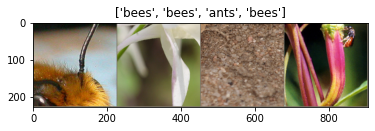

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions

Generic function to display predictions for a few images




In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [8]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.5837 Acc: 0.6885
val Loss: 0.2554 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.4413 Acc: 0.8279
val Loss: 0.3505 Acc: 0.8497

Epoch 2/24
----------
train Loss: 0.4771 Acc: 0.7992
val Loss: 0.8295 Acc: 0.8235

Epoch 3/24
----------
train Loss: 0.7145 Acc: 0.7664
val Loss: 0.9928 Acc: 0.7908

Epoch 4/24
----------
train Loss: 0.8151 Acc: 0.7951
val Loss: 0.5341 Acc: 0.8105

Epoch 5/24
----------
train Loss: 0.8455 Acc: 0.7787
val Loss: 0.7486 Acc: 0.7712

Epoch 6/24
----------
train Loss: 0.7773 Acc: 0.7254
val Loss: 0.3417 Acc: 0.8497

Epoch 7/24
----------
train Loss: 0.4763 Acc: 0.7869
val Loss: 0.2387 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.3185 Acc: 0.8566
val Loss: 0.2280 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.3055 Acc: 0.8484
val Loss: 0.2532 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.3385 Acc: 0.8525
val Loss: 0.2204 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.3137 Acc: 0.8689
val Loss: 0.2155 Acc: 0.9412

Epoch 12/24
----------
t

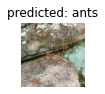

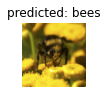

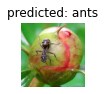

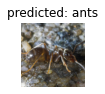

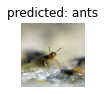

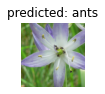

In [10]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [11]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [12]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5839 Acc: 0.6721
val Loss: 0.2237 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.3468 Acc: 0.8730
val Loss: 0.1810 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.3901 Acc: 0.8320
val Loss: 0.1970 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.4457 Acc: 0.8115
val Loss: 0.2530 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.4003 Acc: 0.8320
val Loss: 0.2084 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.5988 Acc: 0.7746
val Loss: 0.2341 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.6182 Acc: 0.7787
val Loss: 0.2534 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.3592 Acc: 0.8689
val Loss: 0.2050 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3171 Acc: 0.8566
val Loss: 0.2169 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.4258 Acc: 0.7992
val Loss: 0.1921 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.2921 Acc: 0.9057
val Loss: 0.2093 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3900 Acc: 0.8484
val Loss: 0.1912 Acc: 0.9477

Ep

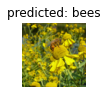

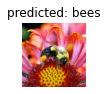

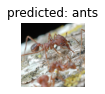

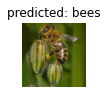

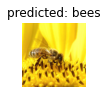

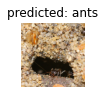

In [13]:
visualize_model(model_conv)

plt.ioff()
plt.show()

##### Copyright 2021 PyTorch.